# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines. 


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

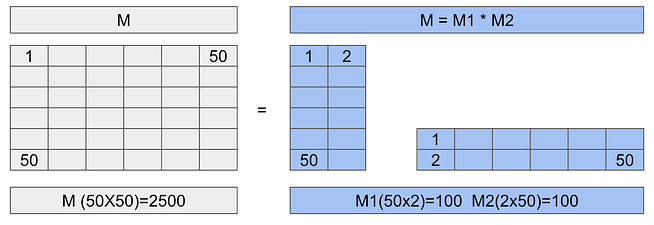

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
! pip install -q peft==0.8.2
! pip install -q datasets==2.16.1
! pip install ipywidgets==7.7.5

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloomz-560m"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [3]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [4]:
#Inference original model
input_sentences = tokenizer("YOUR QUERE HERE ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


['YOUR QUERE HERE  is a book by the author of The Greatest Hits']


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [5]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns('act')

display(train_sample)

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [6]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

# Fine-Tuning.
First is necesary create a LoRA config.


In [7]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [8]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 393,216 || all params: 559,607,808 || trainable%: 0.07026635339584111
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [9]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [10]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=True
)

2024-10-10 13:57:53.370023: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 13:57:53.370090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 13:57:53.371903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 13:57:53.382404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 13:57:55.523966: W tensorflow/compiler/tf2

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [11]:
!pip install ipython==8.16.1
!pip install wandb --update

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.0/807.0 kB 11.0 MB/s eta 0:00:0000:01:01
  Attempting uninstall: ipython
    Found existing installation: ipython 8.20.0
    Uninstalling ipython-8.20.0:
      Successfully uninstalled ipython-8.20.0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --update


pip install ipython==8.16.1
pip install wandb --update

In [ ]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

In [14]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [15]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## Inference the fine-tuned model.

In [16]:
input_sentences = tokenizer("YOUR QUERY GOES HERE", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


['I want you to act as a motivational coach.  I will provide some information about my life and goals for the next few months, then give it up. My first request is "I need help finding motivation in everyday activities"  You should be able to: "help people find their purpose through daily practices of']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

In [ ]:
# Load the necessary libraries and install missing ones
# PEFT: Parameter-Efficient Fine-Tuning, library from Hugging Face for LoRA fine-tuning.
# datasets: Used for accessing a wide variety of prebuilt datasets.
# ipywidgets: For better user interaction in Jupyter Notebooks.
!pip install -q peft==0.8.2
!pip install -q datasets==2.16.1
!pip install ipywidgets==7.7.5


Step 1 install the model and tokenizer

In [ ]:
# Importing the model and tokenizer from the Hugging Face transformers library
# We'll use Bloomz-560M model for causal language modeling (small-sized Bloom model)
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloomz-560m"

# Loading the tokenizer, which converts input text into tokens the model can process
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Loading the pre-trained model without any fine-tuning
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)


Step 2: Model Inference (Before Fine-Tuning)

In [ ]:
# Function to generate text from the pre-trained model without fine-tuning
# max_new_tokens: Specifies the maximum number of new tokens to generate
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, # Helps reduce repeated tokens
        early_stopping=True,    # Allows model to stop when a sensible answer is generated
        eos_token_id=tokenizer.eos_token_id  # Stops generation at the end of the sentence
    )
    return outputs

# Performing inference with the pre-trained model
# Here, we're just checking the model's behavior before any fine-tuning
input_sentences = tokenizer("YOUR QUERY HERE", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

# Decoding the output tokens back into human-readable text
print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Step 3: Load Dataset for Fine-Tuning

In [ ]:
# Loading the dataset that contains prompts to fine-tune the model
# The dataset used here is "awesome-chatgpt-prompts", which has prompts for GPT-based models
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

# Load the dataset from Hugging Face's dataset library
data = load_dataset(dataset)

# Tokenizing the prompts column and preparing data for training
# We apply the tokenizer to the 'prompt' column, which contains the training data
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)

# Selecting a small subset for faster training (50 samples) for demonstration purposes
train_sample = data["train"].select(range(50))

# Dropping the 'act' column as we are only interested in the prompt part for training
train_sample = train_sample.remove_columns('act')

# Displaying the structure of the dataset for verification
print(train_sample[:1])


Step 4: Configuring LoRA Tuning

In [ ]:
# Importing LoRA-related classes for parameter-efficient tuning
import peft
from peft import LoraConfig, get_peft_model, PeftModel

# Configuring the LoRA parameters
# r: Controls the number of parameters trained (higher r means more parameters are trained)
# lora_alpha: Scaling factor for the magnitude of weight updates
# target_modules: Specifies which part of the model is being modified (query_key_value in this case)
# lora_dropout: Regularization to prevent overfitting
lora_config = LoraConfig(
    r=4, # Number of parameters trained
    lora_alpha=1, # Scaling factor
    target_modules=["query_key_value"], # Specify the part of the model being modified
    lora_dropout=0.05, # Dropout to avoid overfitting
    bias="lora_only", # Specifies that only LoRA-related biases are trained
    task_type="CAUSAL_LM" # Task type: causal language modeling
)

# Wrapping the foundation model with PEFT (LoRA) for fine-tuning
peft_model = get_peft_model(foundation_model, lora_config)

# Displaying the number of trainable parameters (LoRA reduces it significantly)
print(peft_model.print_trainable_parameters())


Step 5: Fine-Tuning the Model

In [ ]:
# Creating a working directory to save the fine-tuned model
import os
working_dir = './'
output_directory = os.path.join(working_dir, "peft_lab_outputs")

# Defining training arguments for fine-tuning
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Automatically find the optimal batch size
    learning_rate= 3e-2,       # Higher learning rate for faster fine-tuning
    num_train_epochs=2,        # Number of epochs (iterations over the data)
    use_cpu=True               # Using CPU for demonstration (set to GPU for larger datasets)
)

# Creating a Trainer instance for fine-tuning
# Trainer: A high-level API from Hugging Face to handle training loops
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,  # Training data
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False) # Prepares batches
)

# Training the model (this step may take some time)
trainer.train()

# Saving the fine-tuned model to the specified directory
peft_model_path = os.path.join(output_directory, f"lora_model")
trainer.model.save_pretrained(peft_model_path)


Step 6: Load and Test the Fine-Tuned Model

In [ ]:
# Loading the fine-tuned model for inference
loaded_model = PeftModel.from_pretrained(foundation_model, peft_model_path, is_trainable=False)

# Running inference on the fine-tuned model to observe changes in the generated output
input_sentences = tokenizer("YOUR QUERY GOES HERE", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

# Decoding and printing the result from the fine-tuned model
print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))


Key Learnings:

LoRA tuning significantly reduces the number of parameters trained, leading to more efficient fine-tuning.
Fine-tuning with a smaller dataset (50 samples) can still yield meaningful improvements over the pre-trained model, especially when specialized tasks are required.
The output from the fine-tuned model aligns more closely with the dataset prompts compared to the pre-trained model.
Challenges/Observations:

Fine-tuning for a specific task requires careful adjustment of r and other LoRA-specific parameters to strike a balance between training complexity and generalization.
There is a notable improvement in generated responses after fine-tuning, particularly for task-specific instructions like acting as a "motivational coach."





